In [1]:
%load_ext autoreload
%autoreload 2

import pinot
import torch
import os
import logging
import time
import pickle
import gpytorch
import numpy as np
import sklearn
import matplotlib.pyplot as plt

Using backend: pytorch


# Load data

In [4]:
data = pinot.data.moonshot_pic50()
all_data = [(g, y) for g, y in data]
all_ys = np.array([y for (g, y) in all_data])

In [13]:
all_data = [(g, y) for g, y in data]
train_data, test_data = pinot.data.utils.split(all_data, [0.8, 0.2])

In [9]:
all_ys = np.array([y for (g, y) in all_data])

Text(0, 0.5, 'Number of data points')

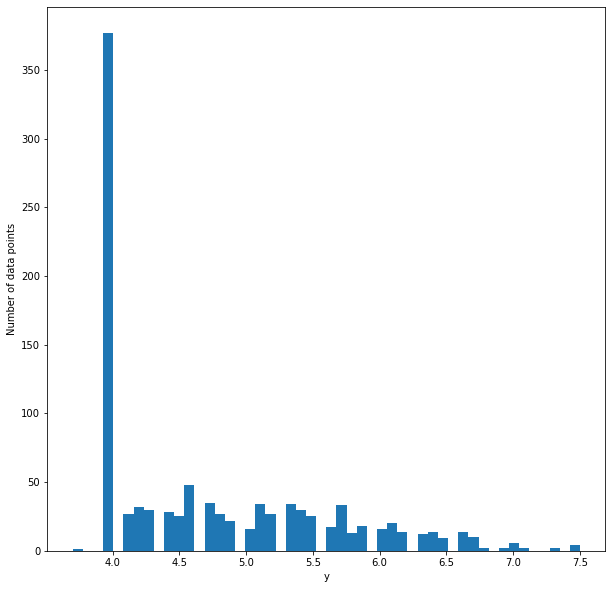

In [12]:
plt.figure(figsize=(10,10))
plt.hist(all_ys, 50)
plt.xlabel("y")
plt.ylabel("Number of data points")

# Now do training

In [17]:
def rmse(y, yhat):
    return torch.sqrt(torch.mean((y.flatten()-yhat.flatten())**2))

def run_vgp_pytorch_experiment(num_inducing, ds_tr_batched, ds_te_batched, kernel_name=None, kernel_params=None, mean_name="LinearMean", beta=1.0, device="cpu", n_epochs=50):
    dev = torch.device(device)
    net_variational_gp = pinot.Net(
        pinot.representation.Sequential(
            pinot.representation.dgl_legacy.gn(kwargs={"allow_zero_in_degree":True}),
                [64, 'relu', 64, 'relu', 64, 'relu']),
        output_regressor_class=pinot.regressors.VariationalGP,
        n_inducing_points=num_inducing,
        beta = beta,
        covar = getattr(gpytorch.kernels, kernel_name)(**kernel_params) if kernel_name is not None else None
    ).to(dev)
    
    lr = 1e-4
    optimizer = torch.optim.Adam([
        {'params': net_variational_gp.representation.parameters(), 'weight_decay': 1e-4},
        {'params': net_variational_gp.output_regressor.parameters(), 'lr': lr*0.1}
    ], lr=lr)
    
    start = time.time()
    for n in range(n_epochs):
        total_loss = 0.
        for (g, y) in ds_tr_batched:
            optimizer.zero_grad()
            loss = net_variational_gp.loss(g.to(dev), y.flatten().to(dev))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
    squared_error_tr = 0.
    n_train = 0
    squared_error_te = 0.
    n_test = 0
    
    for (g, y) in ds_tr_batched:
        n_train += len(y)
        yhat = net_variational_gp.condition(g.to(dev)).mean.cpu()
        squared_error_tr += torch.sum((y.flatten()-yhat.flatten())**2)
        
    
    for (g, y) in ds_te_batched:
        n_test += len(y)
        yhat = net_variational_gp.condition(g.to(dev)).mean.cpu()
        squared_error_te += torch.sum((y.flatten()-yhat.flatten())**2)
    
    train_rmse = torch.sqrt(squared_error_tr/n_train)
    test_rmse = torch.sqrt(squared_error_te/n_test)
    end = time.time()
    
    print(f"VGP (Pytorch) Train rmse = {train_rmse}, test rmse = {test_rmse} for {kernel_name} kernel, beta = {beta}, num_inducing_points = {num_inducing}, mean = {mean_name}, time = {end-start}")
    return net_variational_gp
    
    
def run_vgp_experiment(num_inducing, ds_tr_batched, ds_te_batched, kernel_name=None, kernel_params=None, mean_name="LinearMean", beta=1.0, device="cpu", n_epochs=50):
    dev = torch.device(device)
    net_variational_gp = pinot.Net(
        pinot.representation.Sequential(
            pinot.representation.dgl_legacy.gn(kwargs={"allow_zero_in_degree":True}),
                [64, 'relu', 64, 'relu', 64, 'relu']),
        output_regressor_class=pinot.regressors.VariationalGaussianProcessRegressor,
        n_inducing_points=num_inducing
    ).to(dev)
    
    lr = 1e-4
    optimizer = torch.optim.Adam([
        {'params': net_variational_gp.representation.parameters(), 'weight_decay': 1e-4},
        {'params': net_variational_gp.output_regressor.parameters(), 'lr': lr*0.1}
    ], lr=lr)
    
    start = time.time()
    for n in range(n_epochs):
        total_loss = 0.
        for (g, y) in ds_tr_batched:
            optimizer.zero_grad()
            loss = net_variational_gp.loss(g.to(dev), y.flatten().to(dev))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    squared_error_tr = 0.
    n_train = 0
    squared_error_te = 0.
    n_test = 0
    
    for (g, y) in ds_tr_batched:
        n_train += len(y)
        yhat = net_variational_gp.condition(g.to(dev)).mean.cpu()
        squared_error_tr += torch.sum((y.flatten()-yhat.flatten())**2)
        
    
    for (g, y) in ds_te_batched:
        n_test += len(y)
        yhat = net_variational_gp.condition(g.to(dev)).mean.cpu()
        squared_error_te += torch.sum((y.flatten()-yhat.flatten())**2)
    
    train_rmse = torch.sqrt(squared_error_tr/n_train)
    test_rmse = torch.sqrt(squared_error_te/n_test)
    
    end = time.time()
    print(f"VGP Train rmse = {train_rmse}, test rmse = {test_rmse} for {kernel_name} kernel, beta = {beta}, num_inducing_points = {num_inducing}, mean = {mean_name}, time = {end-start}")
    return net_variational_gp


In [16]:
batch_size = 32
ds_tr_batched  = pinot.data.utils.batch(train_data, batch_size)
ds_te_batched = pinot.data.utils.batch(test_data, batch_size)


In [25]:
n_epochs = 500
num_inducing = 400
vgp_pytorch = run_vgp_pytorch_experiment(num_inducing, ds_tr_batched, ds_te_batched, "RBFKernel", {}, device="cuda", n_epochs=n_epochs)

VGP (Pytorch) Train rmse = 1.0664124488830566, test rmse = 1.153848648071289 for RBFKernel kernel, beta = 1.0, num_inducing_points = 400, mean = LinearMean, time = 476.57427167892456


In [26]:

print(vgp_pytorch.condition(ds_te_batched[0][0].to(torch.device("cuda"))).mean)

tensor([5.3533, 3.3177, 3.5358, 4.5628, 4.4440, 3.9767, 4.9748, 2.5144, 2.9575,
        4.4615, 1.6951, 5.4024, 3.9388, 4.8422, 5.5997, 5.3198, 3.4552, 5.9828,
        3.7343, 6.1566, 5.1174, 4.4126, 3.8361, 4.6145, 4.1536, 4.4109, 3.5869,
        4.3214, 5.6809, 4.0563, 4.3001, 5.1315], device='cuda:0',
       grad_fn=<AddBackward0>)


In [27]:
vgp = run_vgp_experiment(num_inducing, ds_tr_batched, ds_te_batched, "RBFKernel", {}, device="cuda", n_epochs=n_epochs)

VGP Train rmse = 4.60581636428833, test rmse = 4.710196018218994 for RBFKernel kernel, beta = 1.0, num_inducing_points = 400, mean = LinearMean, time = 544.0692403316498


In [29]:
print(vgp.condition(ds_te_batched[0][0].to(torch.device("cuda"))).mean)

tensor([0.2629, 0.2409, 0.2089, 0.2554, 0.2005, 0.2241, 0.2607, 0.2145, 0.2509,
        0.2358, 0.2050, 0.2383, 0.2345, 0.2409, 0.2099, 0.2166, 0.2343, 0.2530,
        0.2284, 0.2520, 0.2482, 0.2545, 0.2071, 0.2551, 0.2112, 0.2171, 0.2443,
        0.2450, 0.2491, 0.2398, 0.2196, 0.2667], device='cuda:0',
       grad_fn=<SelectBackward>)
